In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

In [2]:
class SPDReNMF:
    def __init__(self, spd_data):
        self.data = np.clip(spd_data, 0, None)
        self.wavelengths = np.arange(380, 780)
        self.mu = np.array([415, 445, 480, 515, 555, 590, 630, 680])
        self.sigma = np.array([11.0403, 12.7388, 15.2866, 16.5605, 16.5605, 16.9851, 21.2314, 22.0807])
        self.gaussian_filter()

    def gaussian_filter(self):
        filters = np.zeros((len(self.mu), len(self.wavelengths)))
        for i in range(len(self.mu)):
            filters[i] = np.exp(-0.5 * ((self.wavelengths - self.mu[i]) / self.sigma[i])**2)
        self.M = filters

    def train_nmf(self):
        filtered_data = self.M @ self.data
        nmf = NMF(n_components=8)
        self.W = nmf.fit_transform(filtered_data)
        self.H = nmf.components_

    def reconstruct_new_data(self, new_data):
        new_filtered_data = self.M @ new_data
        new_H = np.linalg.pinv(self.W) @ new_filtered_data
        reconstructed_new_filtered_data = self.W @ new_H
        reconstructed_new_data = np.linalg.pinv(self.M) @ reconstructed_new_filtered_data
        return reconstructed_new_data




In [3]:
train_data = np.load("MixSPD_train.npy",allow_pickle=True).T
test_data = np.load("MixSPD_test.npy", allow_pickle=  True).T

In [4]:
train_data.shape

(400, 4528)

In [5]:
test_data.shape

(400, 1133)

In [6]:
R = SPDReNMF(train_data)
R.gaussian_filter()
R.train_nmf()


/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [7]:
re_data = R.reconstruct_new_data(test_data)
re_data.shape

(400, 1133)

In [12]:
def Evaluate(Light, save_path=None):
        s = test_data[:, Light]
        s_re = re_data[:, Light]


        MAE = np.mean(np.absolute(s - s_re))
        RMSE = np.sqrt(np.mean(np.square(s - s_re)))
        RRMSE = RMSE / np.mean(s_re)

        # GFC
        num = abs(np.sum(s * s_re))
        denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
        denom_s_re = np.sqrt(np.sum(s_re ** 2) + 1e-9)
        GFC = num / (denom_s * denom_s_re)

        print("MAE: ", MAE)
        print("RMSE: ", RMSE)
        print("RRMES: ", RRMSE)
        print("GFC: ", GFC)

        if save_path:
            with open(save_path, 'a') as f:
                f.write(f"Light: {Light + 1}\n")
                f.write(f"MAE: {MAE}\n")
                f.write(f"RMSE: {RMSE}\n")
                f.write(f"RRMES: {RRMSE}\n")
                f.write(f"GFC: {GFC}\n\n")
            print(f"Results saved to {save_path}")

In [25]:
with open('output_NMF/NMF_results.txt', 'w') as f:
    f.write('')

Light_list = [0,100,400,600,700,1000]

for i in Light_list:
    Evaluate(i, "output_NMF/NMF_results.txt")

MAE:  0.021794116821394764
RMSE:  0.033531127308662395
RRMES:  0.37051455141617784
GFC:  0.9536185213172665
Results saved to output_NMF/NMF_results.txt
MAE:  0.030138166881779522
RMSE:  0.05031269714424471
RRMES:  0.5764559573348597
GFC:  0.8930769020893251
Results saved to output_NMF/NMF_results.txt
MAE:  0.0005568609533799745
RMSE:  0.0006839977324728946
RRMES:  0.08836883658008564
GFC:  0.9976803853992708
Results saved to output_NMF/NMF_results.txt
MAE:  0.0007565342393402363
RMSE:  0.0009568183345380926
RRMES:  0.11983363913622441
GFC:  0.9957461546011485
Results saved to output_NMF/NMF_results.txt
MAE:  0.025204128722756024
RMSE:  0.040082699525355904
RRMES:  0.4395364260458688
GFC:  0.9331899841662992
Results saved to output_NMF/NMF_results.txt
MAE:  0.020970734336422717
RMSE:  0.03254419525441622
RRMES:  0.35033739157036
GFC:  0.9564293237390531
Results saved to output_NMF/NMF_results.txt


In [15]:
np.save("Trained.npy",re_data)

In [18]:
import os
def Plot(Light, save_path=None):
        # 创建一个包含三个子图的图像
        fig, axs = plt.subplots(3, 1)
        s= test_data[:, Light]
        r = re_data[:, Light]
        wavelengths = np.arange(380, 780)

        # 绘制真实光谱图
        axs[0].plot(wavelengths, s, label='True Spectrum')
        axs[0].set_xlabel('Wavelength (nm)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
        axs[0].legend()

        # 绘制重建光谱图
        axs[1].plot(wavelengths, r, label='Reconstructed Spectrum')
        axs[1].set_xlabel('Wavelength (nm)')
        axs[1].set_ylabel('Intensity')
        axs[1].legend()

        # 绘制重建光谱和真实光谱叠加的图
        axs[2].plot(wavelengths, s, label='True Spectrum')
        axs[2].plot(wavelengths, r, label='Reconstructed Spectrum')
        axs[2].set_xlabel('Wavelength (nm)')
        axs[2].set_ylabel('Intensity')
        axs[2].legend()

        if save_path:
            file_name = f"Light_s{Light + 1}.png"
            plt.savefig(os.path.join(save_path, file_name))

        plt.tight_layout()
        plt.show()

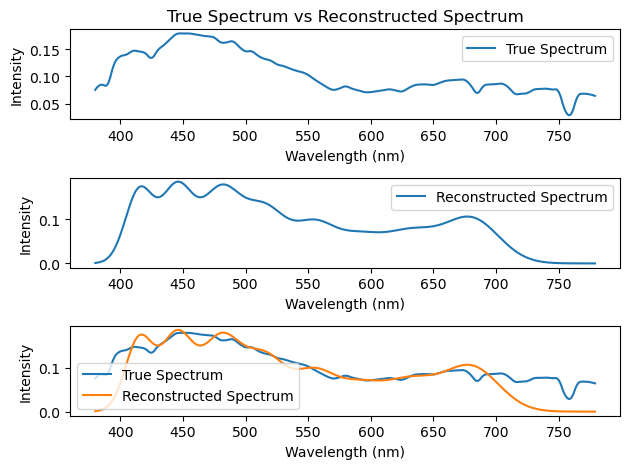

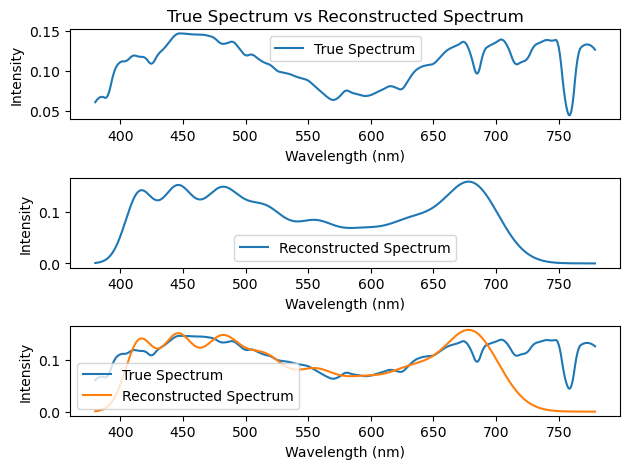

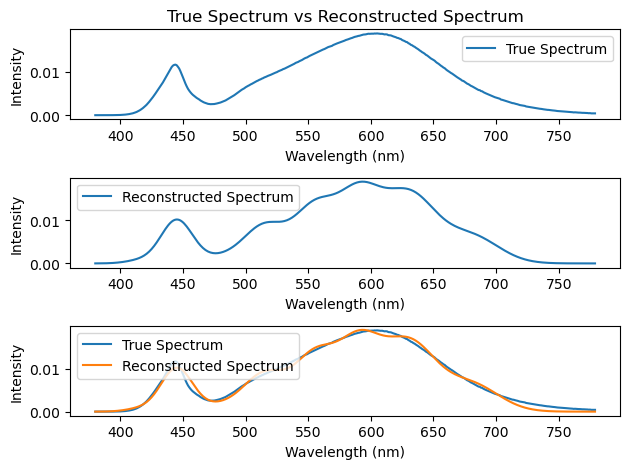

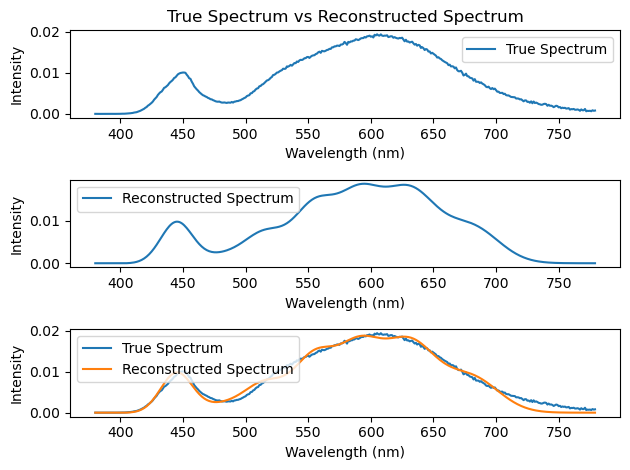

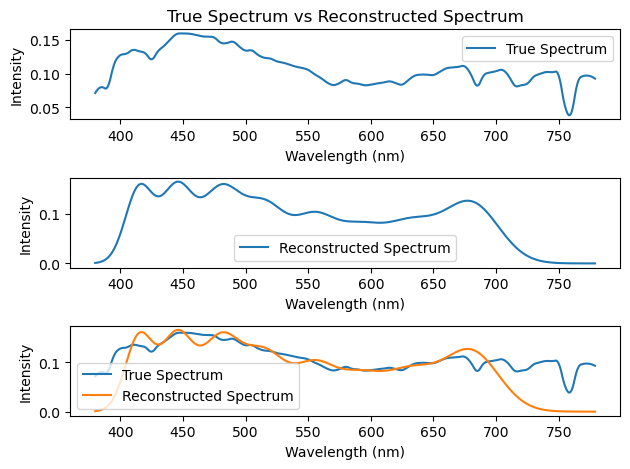

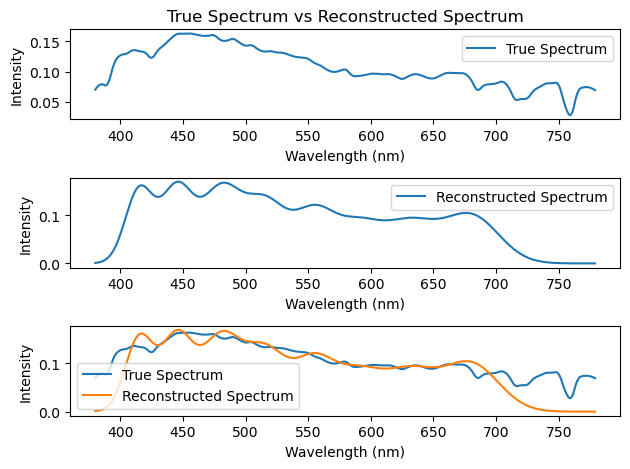

In [19]:
for i in Light_list:
    Plot(i, "output_NMF")

In [23]:
MAE_Total = 0
RMSE_Total =0
GFC_Total = 0

for i in range(len(test_data[1])):
    s = test_data[:, i]
    s_re = re_data[:, i]

    MAE = np.mean(np.absolute(s - s_re))
    RMSE = np.sqrt(np.mean(np.square(s - s_re)))
    RRMSE = RMSE / np.mean(s_re)

    # GFC
    num = abs(np.sum(s * s_re))
    denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
    denom_s_re = np.sqrt(np.sum(s_re ** 2) + 1e-9)
    GFC = num / (denom_s * denom_s_re)

    MAE_Total = MAE_Total + MAE
    RMSE_Total = RMSE_Total + RMSE
    GFC_Total = GFC_Total + GFC

MAE_Total = MAE_Total/len(test_data[1])
RMSE_Total =RMSE_Total/len(test_data[1])
GFC_Total = GFC_Total/len(test_data[1])


In [26]:
print(MAE_Total)
print(RMSE_Total)
print(GFC_Total)

0.013236312993424934
0.02147957123030645
0.9573469312625635


In [27]:
with open('output_NMF/NMF_results.txt', 'a') as f:
                f.write(f"Total:\n")
                f.write(f"Total MAE: {MAE_Total}\n")
                f.write(f"Ttal RMSE: {RMSE_Total}\n")
                f.write(f"Total GFC: {GFC_Total}\n\n")
print(f"Results saved")

Results saved
